## Load data with Dask and without Dask

In [1]:
import datacube
from datacube.utils.cog import write_cog

datacube.__version__

'1.8.12'

In [2]:
dc = datacube.Datacube()


common_params = dict(
    product="ga_s2am_ard_3",
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    crs="EPSG:3577",
    time=("2020-01-05"),
    resolution=(-10, 10),
    output_crs="EPSG:3577",
    resampling={"*": "average"},
    group_by="solar_day",
)


# Load large area with Dask
ds_large_dask = dc.load(
    x=(-1845695, -1824005),
    y=(-2847995, -2815995),
    dask_chunks={"time": 1, "x": 2048, "y": 2048},
    **common_params,
).compute()

# Load large area with no Dask
ds_large_nodask = dc.load(
    x=(-1845695, -1824005),
    y=(-2847995, -2815995),
    **common_params,
)

# Load small area with Dask
ds_small_dask = dc.load(
    x=(-1827131, -1824005),
    y=(-2817258, -2819937),
    dask_chunks={"time": 1, "x": 300, "y": 300},
    **common_params,
).compute()

# Load small area with no Dask
ds_small_nodask = dc.load(
    x=(-1827131, -1824005),
    y=(-2817258, -2819937),
    **common_params,
)

# Export to file
write_cog(ds_large_dask.to_array().squeeze("time"), "ds_large_dask.tif", overwrite=True)
write_cog(ds_large_nodask.to_array().squeeze("time"), "ds_large_nodask.tif", overwrite=True)
write_cog(ds_small_dask.to_array().squeeze("time"), "ds_small_dask.tif", overwrite=True)
write_cog(ds_small_nodask.to_array().squeeze("time"), "ds_small_nodask.tif", overwrite=True)

PosixPath('ds_small_nodask.tif')

## Plot differences between Dask-loaded and non-Dask data
Assumption: Data loaded should be identical between Dask and non-Dask data loads

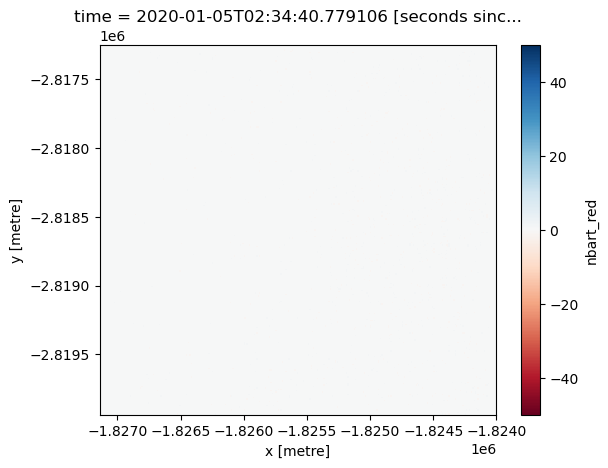

In [3]:
(ds_small_dask - ds_small_nodask).nbart_red.plot(vmin=-50, vmax=50, cmap="RdBu")

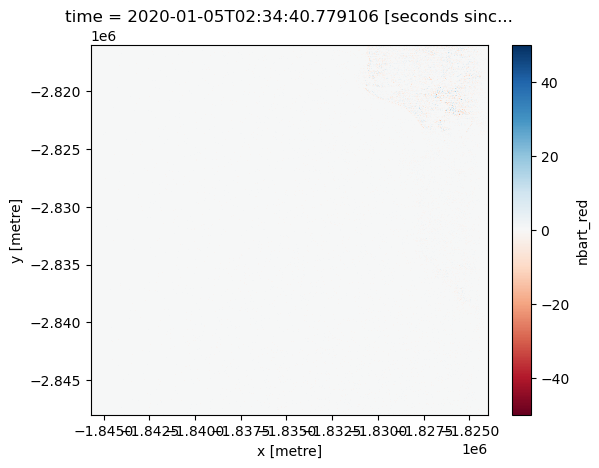

In [4]:
(ds_large_dask - ds_large_nodask).nbart_red.plot(vmin=-50, vmax=50, cmap="RdBu")

### Zoom in

#### Loaded without Dask

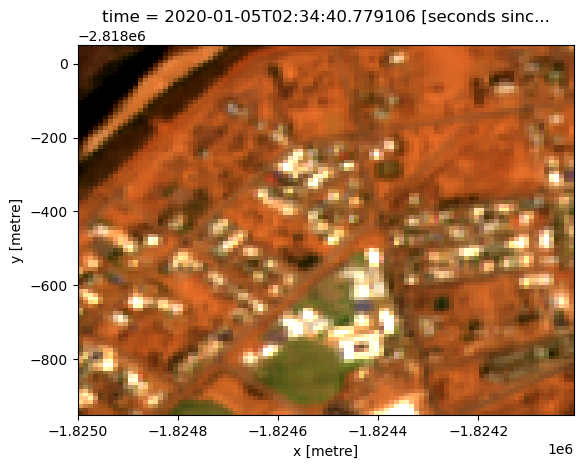

In [5]:
ds_small_nodask.isel(x=slice(-100, -1), y=slice(70, 170)).to_array().squeeze("time").plot.imshow(robust=True, cmap="viridis")

#### Loaded with Dask
Note stretched and blurred data along far right side of image

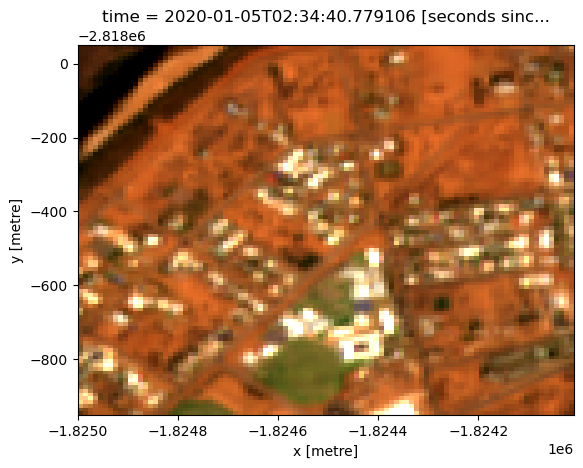

In [6]:
ds_small_dask.isel(x=slice(-100, -1), y=slice(70, 170)).to_array().squeeze("time").plot.imshow(robust=True, cmap="viridis")

#### Difference (shown for one band)

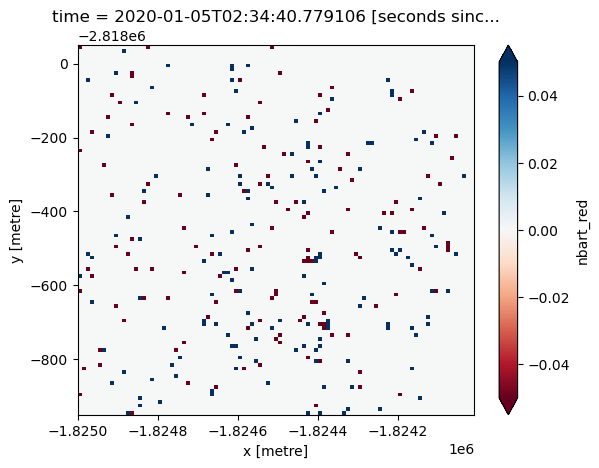

In [7]:
(ds_small_dask - ds_small_nodask).isel(x=slice(-100, -1), y=slice(70, 170)).nbart_red.plot(robust=True, cmap="RdBu")

## Test how small a fractional chunk needs to be

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for chunk_size in np.arange(100, 325, 10):
# Load small area with Dask
    ds_small_dask = dc.load(
        x=(-1827131, -1824005),
        y=(-2817258, -2819937),
        dask_chunks={"time": 1, "x": int(chunk_size), "y": int(chunk_size)},
        **common_params,
    ).compute()
    
    # Plot difference
    fig, ax = plt.subplots(1, 1)
    (ds_small_dask - ds_small_nodask).nbart_red.plot(ax=ax, vmin=-20, vmax=20, cmap="RdBu")
    ax.set_title(f"Dimensions: y: 269, x: 314\nChunk size: y: {int(chunk_size)}, y: {int(chunk_size)}")
    fig.savefig(f"diff_{int(chunk_size)}.jpg")
    

## Test ODC STAC

In [ ]:
import datacube
import pystac_client

import odc.stac
from odc.geo.geobox import GeoBox

# Connect to datacube and setup STAC client
dc = datacube.Datacube()
catalog = pystac_client.Client.open("https://explorer.sandbox.dea.ga.gov.au/stac")

# Set Geobox
gbox = GeoBox.from_bbox(
    (-1827140.0, -2819940.0, -1824000.0, -2817250.0), "epsg:3577", resolution=10
)

# Build a query with the set parameters
query = catalog.search(
    bbox=gbox.geographic_extent.boundingbox,
    collections=["ga_s2am_ard_3"],
    datetime="2020-01-05",
)
items = list(query.get_items())

# Load using ODC Stac, no Dask
ds_stac_nodask = odc.stac.load(
    items,
    bands=("nbart_red"),
    resampling="bilinear",
    groupby="solar_day",
    geobox=gbox,
)

# Load using ODC Stac, with Dask
ds_stac_dask = odc.stac.load(
    items,
    bands=("nbart_red"),
    resampling="bilinear",
    chunks={"x": 300, "y": 300},
    groupby="solar_day",
    geobox=gbox,
).compute()

(ds_stac_dask - ds_stac_nodask).nbart_red.plot(vmin=-50, vmax=50, cmap="RdBu")

## Bilinear experiment

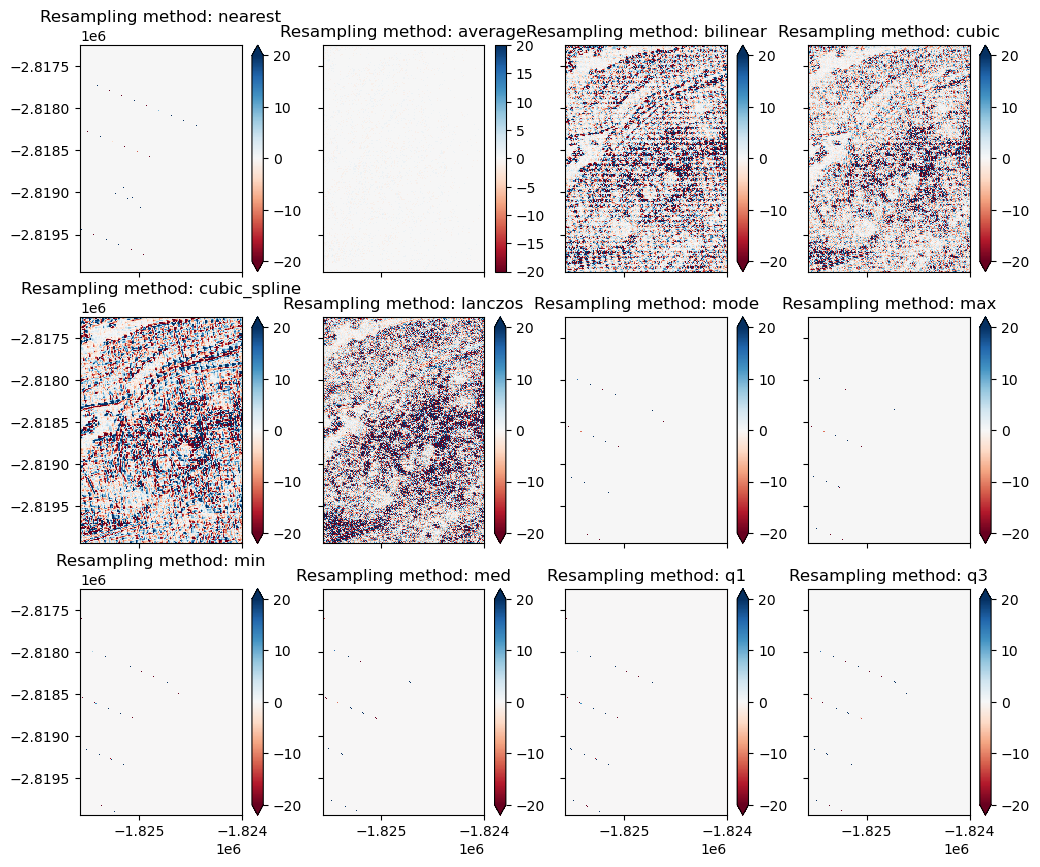

In [11]:
import datacube
from datacube.utils.cog import write_cog
import matplotlib.pyplot as plt

dc = datacube.Datacube()

fig, axes = plt.subplots(3, 4, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, method in enumerate(
    [
        "nearest",
        "average",
        "bilinear",
        "cubic",
        "cubic_spline",
        "lanczos",
        "mode",
        "max",
        "min",
        "med",
        "q1",
        "q3",
    ]
):
    common_params = dict(
        product="ga_s2am_ard_3",
        measurements=["nbart_red", "nbart_green", "nbart_blue"],
        crs="EPSG:3577",
        time=("2020-01-05"),
        resolution=(-10, 10),
        output_crs="EPSG:3577",
        resampling={"*": method},
        group_by="solar_day",
    )

    # Full image
    xmin, xmax = -1827131, -1824005
    ymax, ymin = -2817258, -2819937

    # Load small area with no Dask
    ds_full = dc.load(
        x=(xmin, xmax),
        y=(ymax, ymin),
        **common_params,
    )

    # Right half of the full image
    xmin_mid = xmin + (xmax - xmin) * 0.5

    # Load small area with no Dask
    ds_righthalf = dc.load(
        x=(xmin_mid, xmax),
        y=(ymax, ymin),
        **common_params,
    )

    # Calculate difference; xarray will take care of clipping to shared extent
    (ds_full - ds_righthalf).nbart_red.squeeze("time").plot.imshow(
        ax=axes[i], vmin=-20, vmax=20, cmap="RdBu", add_labels=False
    )
    axes[i].set_title(f"Resampling method: {method}")

    # # Export
    # write_cog(
    #     ds_full.to_array().squeeze("time"), f"ds_full_{method}.tif", overwrite=True
    # )
    # write_cog(
    #     ds_righthalf.to_array().squeeze("time"),
    #     f"ds_righthalf_{method}.tif",
    #     overwrite=True,
    # )

# fig.savefig(f"diff_method.jpg")

In [13]:
fig.savefig(f"diff_method.jpg", bbox_inches="tight")

In [ ]:
(ds_full - ds_righthalf).nbart_red.squeeze("time").plot(robust=True, cmap="viridis")

In [ ]:
# ds_full.to_array().squeeze("time").plot.imshow(robust=True, cmap="viridis", size=8, aspect=1.0)

In [ ]:
# ds_righthalf.to_array().squeeze("time").plot.imshow(robust=True, cmap="viridis", size=8, aspect=0.5)

In [ ]:
(ds_full - ds_righthalf).nbart_red.squeeze("time").plot.imshow(robust=True, cmap="viridis")